In [1]:
#Install dependencies if running in a new environment
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Geodemographic python example
This notebook contains the workflow for produceding a geodemographic classification in python using k-means clustering. It follows a simplified process, similar to that described in the [2021 OAC Paper](https://rgs-ibg.onlinelibrary.wiley.com/doi/full/10.1111/geoj.12550).

In [18]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from clustergram import Clustergram
import matplotlib.pyplot as plt

#set a  random seed for reproducibility
random_seed = 507

#load the input data from a csv file 
# The names of the columns are not important, BUT;
# the first column should be the geography code (e.g., Output Area or Local Authority District),
# which will be used as the DataFrame index.
# The remaining columns should be variables for clustering, provided as fractions or percentages of the table total.
def load_data(filepath):
    input_df = pd.read_csv(filepath, index_col=0)
    
    # Check for missing values
    missing_values = input_df.isnull().sum().sum()
    if missing_values > 0:
        print(f"Warning: {missing_values} missing values found in input data. Missing values will be replaced with 0.")
        input_df.fillna(0, inplace=True)
    
    return input_df

# File path to the dataset
filepath = "example_oacdata.csv"

# Load the dataset
variable_df = load_data(filepath)
#show first 5 rows of the dataset
variable_df.head()

,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,...,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60
geo_code,,,,,,,,,,,,,,,,,,,,,
geo_00001,0,71,90,55,59,59,82,87,45,13,...,53,41,49,45,50,53,32,73,67,87
geo_00002,0,78,83,74,67,66,81,97,45,32,...,49,67,65,55,52,64,41,86,70,69
geo_00003,65,94,63,51,79,61,63,92,62,41,...,48,50,42,52,45,67,43,65,88,78
geo_00004,0,79,82,73,75,81,76,100,24,0,...,58,60,58,38,57,62,30,82,70,75
geo_00005,43,70,78,77,87,69,55,98,43,0,...,50,52,63,60,60,58,33,82,67,72


In [20]:
def transform_and_standardize_data(df):
    """Apply inverse hyperbolic sine transform, to account for non-normality
      and then range standardize using min-max scaling to the dataframe."""
    df = np.arcsinh(df)
    df = (df - df.min()) / (df.max() - df.min())
    return df

# Transform the input data
transformed_variable_df = transform_and_standardize_data(variable_df)


In [16]:
import seaborn as sns

def check_corrs(df, corr_threshold = 0.9):
    # Compute the correlation matrix
    corr_matrix = df.corr()
    #plot the correlation matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.show()

    # Find the pairs of highly correlated columns
    # Create a mask to exclude the diagonal (correlation of a column with itself)
    highly_corr = np.where((corr_matrix > corr_threshold ) & (corr_matrix != 1))

    # List to keep track of columns to remove
    columns_to_remove = set()
    # Loop through the pairs and add one column to remove for each pair of high correlation
    for i, j in zip(*highly_corr):
        colname_i = corr_matrix.columns[i]
        colname_j = corr_matrix.columns[j]
        # Keep the column that has the most information or less missing data
        if colname_i not in columns_to_remove:
            columns_to_remove.add(colname_j)  # Add the second column of the pair for removal

    # Remove the columns with high correlation
    df_cleaned = df.drop(columns=columns_to_remove)
    # Show the cleaned dataframe
    print(f"Removed columns: {columns_to_remove}")
    return df_cleaned

# Clustergrams
We produce a clustergram plot to assess an apprioate number of clusters for the supergroups.
For OAC, eight superclusters were created.
Some guidence on interpretting clustergrams and choosing the can be found here; https://clustergram.readthedocs.io/en/stable/notebooks/introduction.html

In [19]:

def create_clustergram(df, n_init, save_loc, random_seed=random_seed):
    """
    Create and save a clustergram for evaluating k-means clustering solutions.

    The clustergram visualizes clustering stability and helps identify the optimal 
    number of clusters by performed the k-means algorithm for a range of cluster
    numbers.
    Since k-means is sensitive to initialization, `n_init` determines the number of 
    times the algorithm runs with different centroid seeds. The final result is the 
    best outcome based on inertia/WCSS (within-cluster sum of squares.

    Parameters:
    df (pd.DataFrame or np.ndarray): The input data for clustering.
    n_init (int): Number of k-means runs with different initial centroid seeds. 
                  Higher values (e.g., ~1000) improve solution stability but increase runtime.
    save_loc (str): File path to save the clustergram plot.
    random_seed (int, optional): Random seed for reproducibility.
    """
    cgram = Clustergram(range(1, 15), n_init=n_init, random_state=random_seed)  # Initialize clustergram model
    cgram.fit(df)  # Fit model to data
    cgram.plot()  # Generate plot
    plt.savefig(save_loc)  # Save figure
    plt.show()  # Display plot

# Example usage
n_init = 1  # Use a low value for quick testing, increase (~100) for final results
create_clustergram(transformed_variable_df, n_init, save_loc="plots/supergroup_clustergram.png")


NameError: name 'transformed_variable_df' is not defined

In [ ]:
def run_kmeans(input_df,num_clusters, n_init, output_filepath):
    # n_init, number of times the k-means algorithm will run with different centroid seeds,
    # the final results will be the best output of n_init consecutive runs in terms of inertia/wcss
    # for the final results a value of ~1000 is reccomended, 
    # this can take a while so a lower value can be used for testing
    # Intialise the model;
    kmeans_model = KMeans(n_clusters=num_clusters, max_iter=1000, random_state=random_seed, n_init=n_init)
    #Fit the model on our data and make predictions using the best model.
    # add a cluster column to the input dataframe which contains the assigned cluster for each row
    input_df['cluster'] = kmeans_model.fit_predict(input_df)
    #save a lookup table containing the created clusters
    input_df[['cluster']].to_csv(output_filepath)
    # Show the results
    print(f"K-means clusters:\n{input_df[['cluster']].head()}")  # Show the cluster assignments for the first few rows
    return input_df
# Define the number of clusters (K). You can choose K based on the clustergram plot above
num_clusters = 8  
output_filepath = "outputs/supergroups_clusteroutput.csv"
#if output dir doesn't exist create it
output_df = run_kmeans(input_df, num_clusters ,n_init = 1, output_filepath)

K-means clusters:
           cluster
geo_code          
geo_00001        7
geo_00002        7
geo_00003        3
geo_00004        6
geo_00005        3


# Subgroups
For OAC the supergroup clusters created above are split further into groups and subgroups by applying the above process iteratively. 
Example code for creating the subclusters is below

Cluster: 0, 16958 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster0.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.230 seconds.
K=3 fitted in 0.221 seconds.
K=4 fitted in 0.257 seconds.
K=5 fitted in 0.229 seconds.
K=6 fitted in 0.298 seconds.
K=7 fitted in 0.285 seconds.
K=8 fitted in 0.316 seconds.
K=9 fitted in 0.400 seconds.
K=10 fitted in 0.245 seconds.
K=11 fitted in 0.261 seconds.
K=12 fitted in 0.265 seconds.
K=13 fitted in 0.272 seconds.
K=14 fitted in 0.353 seconds.


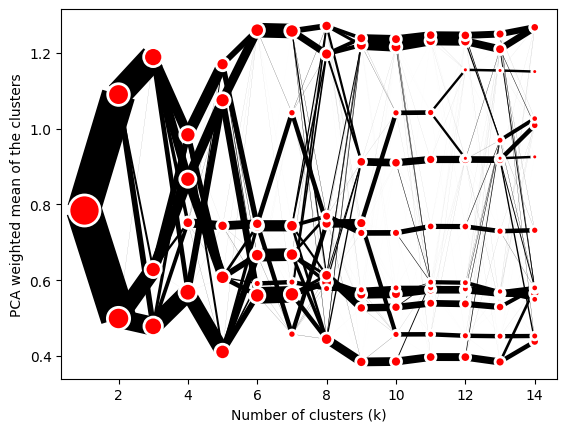

Cluster: 1, 13528 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster1.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.238 seconds.
K=3 fitted in 0.189 seconds.
K=4 fitted in 0.198 seconds.
K=5 fitted in 0.208 seconds.
K=6 fitted in 0.222 seconds.
K=7 fitted in 0.274 seconds.
K=8 fitted in 0.261 seconds.
K=9 fitted in 0.302 seconds.
K=10 fitted in 0.260 seconds.
K=11 fitted in 0.242 seconds.
K=12 fitted in 0.274 seconds.
K=13 fitted in 0.270 seconds.
K=14 fitted in 0.248 seconds.


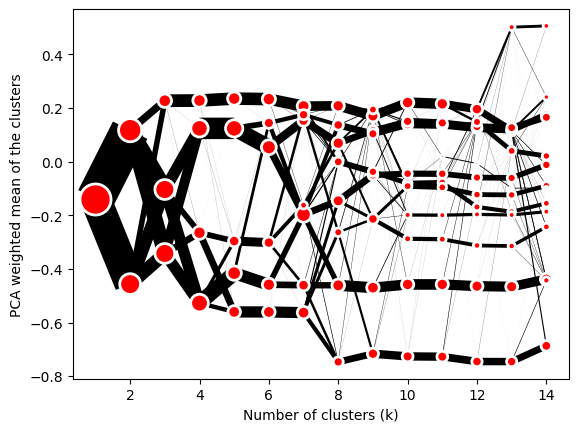

Cluster: 2, 2523 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster2.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.097 seconds.
K=3 fitted in 0.062 seconds.
K=4 fitted in 0.076 seconds.
K=5 fitted in 0.056 seconds.
K=6 fitted in 0.040 seconds.
K=7 fitted in 0.055 seconds.
K=8 fitted in 0.071 seconds.
K=9 fitted in 0.061 seconds.
K=10 fitted in 0.050 seconds.
K=11 fitted in 0.049 seconds.
K=12 fitted in 0.055 seconds.
K=13 fitted in 0.071 seconds.
K=14 fitted in 0.037 seconds.


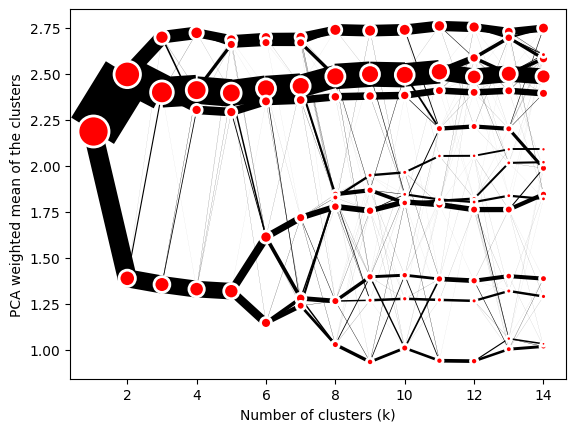

Cluster: 3, 14801 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster3.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.209 seconds.
K=3 fitted in 0.235 seconds.
K=4 fitted in 0.184 seconds.
K=5 fitted in 0.222 seconds.
K=6 fitted in 0.244 seconds.
K=7 fitted in 0.241 seconds.
K=8 fitted in 0.223 seconds.
K=9 fitted in 0.250 seconds.
K=10 fitted in 0.260 seconds.
K=11 fitted in 0.254 seconds.
K=12 fitted in 0.274 seconds.
K=13 fitted in 0.251 seconds.
K=14 fitted in 0.287 seconds.


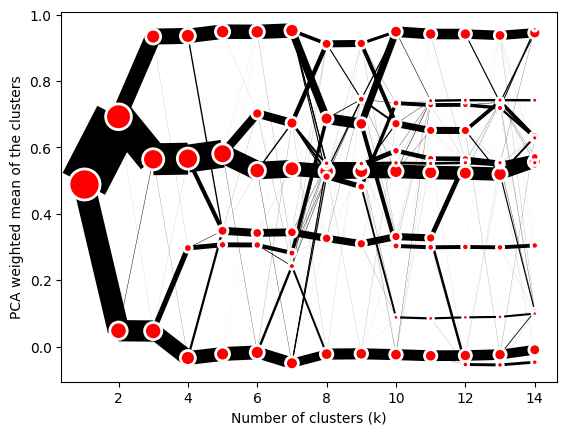

Cluster: 4, 15250 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster4.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.175 seconds.
K=3 fitted in 0.172 seconds.
K=4 fitted in 0.208 seconds.
K=5 fitted in 0.195 seconds.
K=6 fitted in 0.211 seconds.
K=7 fitted in 0.238 seconds.
K=8 fitted in 0.246 seconds.
K=9 fitted in 0.231 seconds.
K=10 fitted in 0.279 seconds.
K=11 fitted in 0.245 seconds.
K=12 fitted in 0.320 seconds.
K=13 fitted in 0.275 seconds.
K=14 fitted in 0.265 seconds.


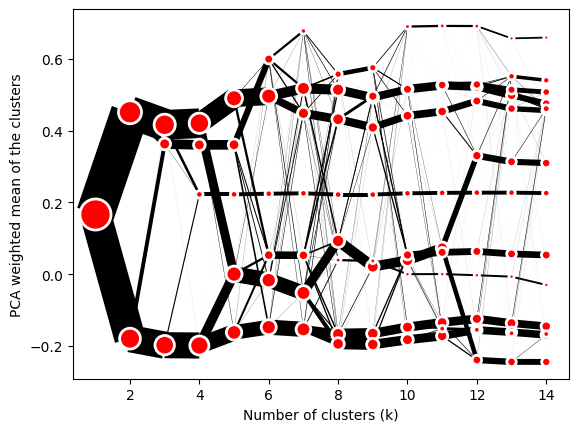

Cluster: 5, 8642 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster5.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.174 seconds.
K=3 fitted in 0.284 seconds.
K=4 fitted in 0.219 seconds.
K=5 fitted in 0.205 seconds.
K=6 fitted in 0.171 seconds.
K=7 fitted in 0.182 seconds.
K=8 fitted in 0.265 seconds.
K=9 fitted in 0.275 seconds.
K=10 fitted in 0.300 seconds.
K=11 fitted in 0.242 seconds.
K=12 fitted in 0.257 seconds.
K=13 fitted in 0.380 seconds.
K=14 fitted in 0.355 seconds.


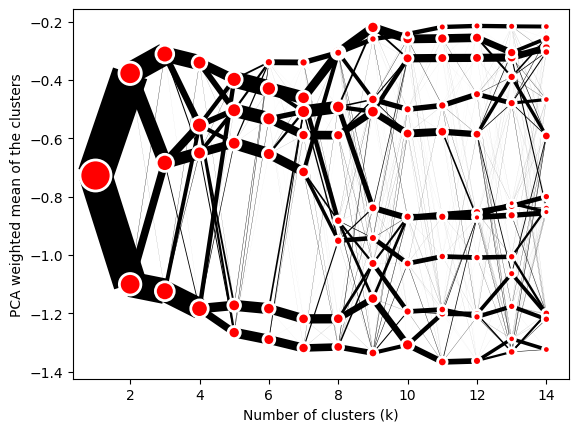

Cluster: 6, 12128 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster6.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.189 seconds.
K=3 fitted in 0.252 seconds.
K=4 fitted in 0.211 seconds.
K=5 fitted in 0.233 seconds.
K=6 fitted in 0.242 seconds.
K=7 fitted in 0.344 seconds.
K=8 fitted in 0.315 seconds.
K=9 fitted in 0.271 seconds.
K=10 fitted in 0.285 seconds.
K=11 fitted in 0.244 seconds.
K=12 fitted in 0.303 seconds.
K=13 fitted in 0.288 seconds.
K=14 fitted in 0.300 seconds.


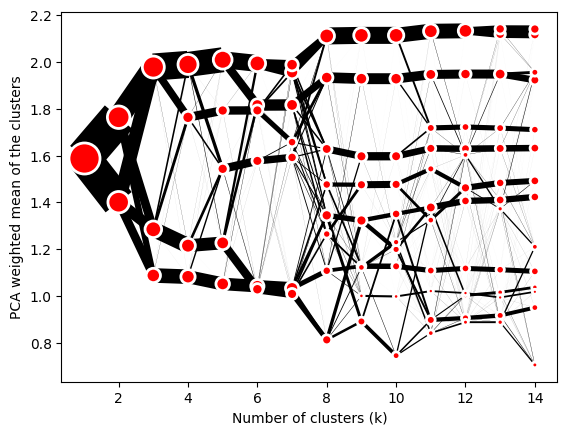

Cluster: 7, 16170 geographies in cluster
Saving clustergram to plots/subcluster_clustergram_cluster7.png
K=1 skipped. Mean computed from data directly.
K=2 fitted in 0.182 seconds.
K=3 fitted in 0.225 seconds.
K=4 fitted in 0.233 seconds.
K=5 fitted in 0.242 seconds.
K=6 fitted in 0.212 seconds.
K=7 fitted in 0.305 seconds.
K=8 fitted in 0.268 seconds.
K=9 fitted in 0.223 seconds.
K=10 fitted in 0.263 seconds.
K=11 fitted in 0.259 seconds.
K=12 fitted in 0.307 seconds.
K=13 fitted in 0.300 seconds.
K=14 fitted in 0.282 seconds.


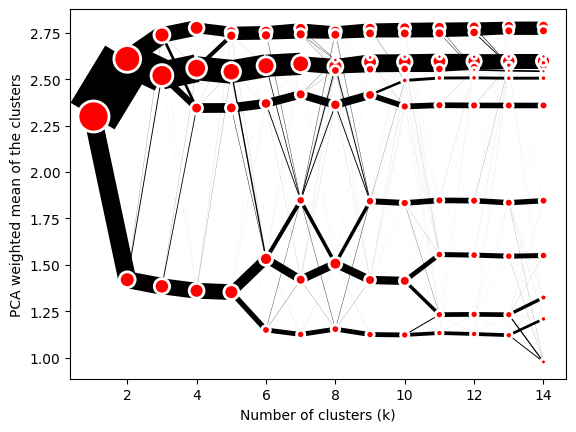

In [ ]:
#create a clustergram for each of the superclusters.

#loop through the existing clusters and create clustergrams for each.
for cluster in range(0,num_clusters):
    # Select rows corresponding to the current cluster, drop the cluster column before clustering
    cluster_df = output_df.query(f"cluster == {cluster}").drop(columns='cluster')
    print(f"Cluster: {cluster}, {len(cluster_df)} geographies in cluster")
    #run the clustergram function to create a clustergram
    save_loc =  f'plots/subcluster_clustergram_cluster{cluster}.png'
    print(f"Saving clustergram to {save_loc}")
    create_clustergram(cluster_df, n_init=1, save_loc=save_loc)


In [12]:

def run_subclustering(output_df: pd.DataFrame, subcluster_nums: list, num_clusters: int, n_init: int = 1) -> pd.DataFrame:
    """
    Runs subclustering for each supergroup using KMeans and returns a modified DataFrame with subcluster labels.
    
    Parameters:
    - output_df (pd.DataFrame): The original DataFrame containing data and cluster assignments.
    - subcluster_nums (list): A list specifying the number of subclusters to split each supergroup into.
    - num_clusters (int): The total number of supergroups.
    - n_init (int, optional): The number of times KMeans will be initialized. Defaults to 1.

    Returns:
    - pd.DataFrame: A new the output dataFrame with an added 'subcluster' column.
    """
    if len(subcluster_nums) != num_clusters:
        raise ValueError(f"Length of subcluster_nums ({len(subcluster_nums)}) does not match num_clusters ({num_clusters}).")

    # Work on a copy of the DataFrame to prevent unintended modifications
    modified_df = output_df.copy()

    for cluster, num_subclusters in zip(range(num_clusters), subcluster_nums):
        print(f"Clustering supergroup {cluster} into {num_subclusters} subclusters.")

        # Select rows corresponding to the current cluster, drop the cluster column before clustering
        cluster_df = modified_df.query(f"cluster == {cluster}").drop(columns='cluster')

        # Run KMeans clustering for the selected supergroup
        subcluster_output_df = run_kmeans(
            cluster_df, 
            num_subclusters, 
            n_init=n_init, 
            output_filepath=f"outputs/supergroup{cluster}_subclusteroutput.csv"
        )

        # Convert 0,1,2,... to a, b, c, ...
        subcluster_output_df['subcluster'] = [str(cluster) + chr(97 + i) for i in subcluster_output_df['cluster']]

        # Update the modified DataFrame with subclustering results
        modified_df.loc[cluster_df.index, 'subcluster'] = subcluster_output_df['subcluster']

    # Save the final output
    modified_df.to_csv('outputs/final_output.csv')
    print("Final output saved to outputs/final_output.csv")

    return modified_df  # Return the modified DataFrame without altering the original


#run the subclustering for each of the supergroups
# We can now select the number of subclusters to split each of the supergroups into using the clustergrams above.
# For this example, we choose three subclusters for each supergroup.
# The length of the list must match num_clusters (the number of supergroups).
subcluster_nums = [3, 3, 3, 3, 3, 3, 3, 3]
# subcluster_nums = [2, 4, 2, 2, 5, 2, 3, 3]

run_subclustering(output_df, subcluster_nums, num_clusters=num_clusters, n_init=1)

Clustering supergroup 0 into 3 subclusters.


ValueError: could not convert string to float: '0b'

In [11]:
output_df

,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,...,v53,v54,v55,v56,v57,v58,v59,v60,cluster,subcluster
geo_code,,,,,,,,,,,,,,,,,,,,,
geo_00001,0.000000,0.935364,0.981978,0.888862,0.902136,0.900424,0.962547,0.856059,0.849310,0.617561,...,0.865379,0.849310,0.869191,0.880186,0.784986,0.944206,0.924420,0.973717,7,NaN
geo_00002,0.000000,0.953109,0.966668,0.944966,0.926177,0.921582,0.960231,0.968517,0.849310,0.787991,...,0.918701,0.887176,0.876592,0.915775,0.831745,0.975254,0.932687,0.929971,7,NaN
geo_00003,0.918701,0.988322,0.914538,0.874586,0.957329,0.906715,0.912803,0.913816,0.909784,0.834928,...,0.836291,0.876592,0.849310,0.924420,0.840731,0.922217,0.975874,0.953109,3,NaN
geo_00004,0.000000,0.955513,0.964376,0.942394,0.947504,0.960231,0.948207,1.000000,0.730726,0.000000,...,0.897198,0.817408,0.893916,0.909784,0.772812,0.966231,0.932687,0.945707,6,NaN
geo_00005,0.840731,0.932687,0.954920,0.952480,0.975568,0.929971,0.887176,0.979118,0.840731,0.000000,...,0.912803,0.903596,0.903596,0.897198,0.790792,0.966231,0.924420,0.938003,3,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
geo_99996,0.000000,0.982201,0.898903,0.944966,0.984068,0.921582,0.909784,0.968517,0.887176,0.000000,...,0.887176,0.909784,0.817408,0.887176,0.876592,0.977444,0.766417,0.962547,1,NaN
geo_99997,0.000000,0.924420,0.984068,0.923334,0.923334,0.948207,0.964835,0.979118,0.796423,0.438116,...,0.822309,0.861488,0.831745,0.840731,0.730726,0.959170,0.935364,0.962547,3,NaN
geo_99998,0.000000,0.915775,0.981978,0.895615,0.954920,0.924420,0.932687,0.957806,0.790792,0.787991,...,0.876592,0.822309,0.696351,0.600147,0.807207,0.963907,0.915775,0.964835,3,NaN
